In [411]:
%pip install pandas openpyxl torch scikit-learn facenet-pytorch matplotlib torchsampler opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 827.6 kB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# Assuming the xlsx file is named 'data.xlsx'
df = pd.read_excel('dataset/dataset.xlsx', engine='openpyxl')

imgs_with_b = df[df['B'] == 1] # get all rows where the df['B'] is 1
imgs_with_c = df[df['C'] == 1] # get all rows where the df['C'] is 1
imgs_with_d = df[df['D'] == 1] # get all rows where the df['D'] is 1

balanced_imgs_with_b = imgs_with_b.sample(frac=1, replace=True)
balanced_imgs_with_c = imgs_with_c.sample(frac=5.03, replace=True)
balanced_imgs_with_d = imgs_with_d.sample(frac=1.4, replace=True)

# concat all dataframes
df = pd.concat([balanced_imgs_with_b, balanced_imgs_with_c, balanced_imgs_with_d], ignore_index=True)

# duplicate all rows 
df = df.sample(frac=6, replace=True)

imgs_with_c = df[df['C'] == 1]
imgs_with_d = df[df['D'] == 1]
imgs_with_b = df[df['B'] == 1]

print('imgs_with_b', len(imgs_with_b))
print('imgs_with_c', len(imgs_with_c))
print('imgs_with_d', len(imgs_with_d))

# Extract image names and class labels
image_names = df['A'].tolist()
class_labels = df[['B', 'C', 'D']].values
print(df)


imgs_with_b 5844
imgs_with_c 5834
imgs_with_d 5425
                                                      A  B  C  D
337        Porcelain-Veneers-before-4401096-2941002.jpg  1  0  0
2575       Porcelain-Veneers-before-7369886-3622563.jpg  0  0  1
2146       Porcelain-Veneers-before-7209121-3580754.JPG  0  0  1
599        Porcelain-Veneers-before-1691637-2215342.PNG  1  0  0
833       Porcelain-Veneers-before-10526516-4646618.JPG  1  0  0
...                                                 ... .. .. ..
1763        Dental-Implants-before-11711134-5005075.png  0  1  0
1634      Porcelain-Veneers-before-12858539-5736880.jpg  0  1  0
173       Porcelain-Veneers-before-11606211-4955373.png  1  0  0
2563                                   image B (36).jpg  0  0  1
1011  202170762_4028165987278602_7807998386609379199...  0  1  0

[16998 rows x 4 columns]


In [2]:
from PIL import Image
from torchvision import transforms

global_tranformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),


    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([
        transforms.RandomAffine(0),
        transforms.ColorJitter(),
        transforms.GaussianBlur(5),
    ]),
])

def load_image(image_name):
    image_path = "/root/ortho-ai/dataset/imgs/" + image_name
    img = Image.open(image_path).convert('RGB') # Open and convert to RGB
    return global_tranformer(img)

In [3]:
import torch.utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch.utils.data
from torchvision import transforms
import torch

# empty image dictionary map<string,Image>


class MyData(Dataset):
    def __init__(self, images_names, class_labels, transform=None):
        self.images_names = images_names
        self.class_labels = class_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, index):
        image = self.images_names[index]
        label = self.class_labels[index]
        
        # get image from dictionary or load it
        
        image = load_image(image)
        
        # Apply augmentation only to the minority class
        # if (label[1] == 1 or label[0] == 1 ) and self.transform:
        if (label[1] == 1 or label[0] == 1) and self.transform:
            image = self.transform(image)
        
        return image, label
    
    
# augmentation = transforms.Compose([
#     transforms.GaussianBlur(5),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(0),
# ])

augmentation = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0),
        transforms.ColorJitter(),
        transforms.GaussianBlur(5),
    ]),
])


# Split data into training and test sets (80% training, 20% test)
images_train, images_test, labels_train, labels_test = train_test_split(image_names, class_labels, test_size=0.2, random_state=42)

# Calculate class weights based on the presence of each class across all columns
class_counts = torch.sum(torch.tensor(class_labels), dim=0)
class_weights = 1. / class_counts.float()

print(class_weights)

# Create a list of weights for each training sample
weights = torch.sum(class_weights[labels_train], dim=1)

# Create WeightedRandomSampler for imbalanced classes
sampler = WeightedRandomSampler(weights, len(weights))

# Create your dataset
train_dataset = MyData(images_train, labels_train, transform=augmentation, )
full_dataset = MyData(image_names, class_labels, transform=augmentation)
test_dataset = MyData(images_test, labels_test)

# Create a DataLoader
train_dataloader = DataLoader(full_dataset, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=64)

tensor([0.0002, 0.0002, 0.0002])


In [18]:
from torchvision.models import resnet50 # You can choose other ResNet models like resnet34, resnet50, etc.
import torch
import torch.optim as optim

# Load the ResNet model

model = resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the final layer to match the number of classes
num_classes = 3 # Adjust this to the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert labels to LongTensor
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

Epoch 1, Loss: 0.3737800594051959
Epoch 2, Loss: 0.11424629864645816
Epoch 3, Loss: 0.060597987572264644
Epoch 4, Loss: 0.058205040215466505
Epoch 5, Loss: 0.049446804059818036
Epoch 6, Loss: 0.0395002933943255
Epoch 7, Loss: 0.04316379832286396
Epoch 8, Loss: 0.02801348826221623
Epoch 9, Loss: 0.018995361777837935
Epoch 10, Loss: 0.0588406341486805
Epoch 11, Loss: 0.02294550496992489
Epoch 12, Loss: 0.020737250479257407
Finished Training


In [17]:
# Evaluate model accuracy on the test set after training
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Convert labels to LongTensor (assuming class labels are integers)
            labels = labels.long()

            outputs = model(images)
            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(outputs)
            # Convert probabilities to binary predictions
            predicted = (probabilities > 0.5).long()

            total += labels.size(0)
            # Calculate correct predictions for each sample
            correct_sample = (predicted == labels).all(dim=1).sum().item()
            correct += correct_sample

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_dataloader)

Test Accuracy: 84.62%


In [9]:
import torch
# Preprocess the image
image = Image.open('test_imgs/WhatsApp Image 2024-05-03 at 17.02.21.jpeg').convert('RGB')
image_tensor = global_tranformer(image).unsqueeze(0) # Add batch dimension

# Move the tensor to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert logits to probabilities using softmaxa
probabilities = torch.nn.functional.softmax(output, dim=1)

# Print the probabilities for all classes
print("Probabilities for all classes:")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")

Probabilities for all classes:
Class 1: 0.648479163646698
Class 2: 0.3046368658542633
Class 3: 0.04688394069671631


In [412]:
# import torch

# torch.save(model, "./models/smile_arc_model_v0.11.pth")

In [4]:
import torch
model = torch.load("./models/smile_arc_model_v0.3.pth")

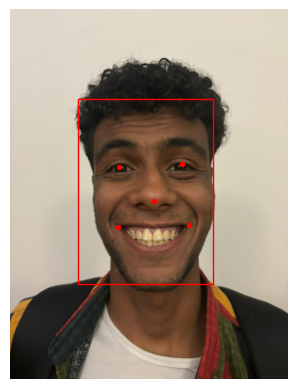

In [10]:
from matplotlib import pyplot as plt
from facenet_pytorch import MTCNN

# Load an image from a local file
image_path = 'test_imgs/WhatsApp Image 2024-05-03 at 17.02.21.jpeg'
image = Image.open(image_path)

# Initialize MTCNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# Detect faces and landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Visualize the detection (optional)
fig, ax = plt.subplots()
ax.imshow(image)
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c='red')
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        ax.add_patch(rect)
plt.axis('off')
plt.show()

# Rotate the image based on mouth landmarks to make the mouth horizontal
mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face


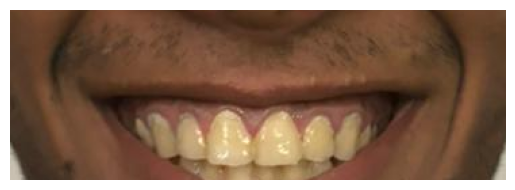

In [11]:
if landmarks is not None:
    margin = 60  # Adjust based on your needs
    mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face
    mouth_box = [
        min(mouth_landmarks[:,0]) - margin,  # Left
        min(mouth_landmarks[:,1]) - margin,  # Top
        max(mouth_landmarks[:,0]) + margin,  # Right
        max(mouth_landmarks[:,1]) + margin    # Bottom
        ]
    mouth_crop = image.crop((mouth_box[0], mouth_box[1], mouth_box[2], mouth_box[3]))

    # Display the cropped mouth region
    plt.imshow(mouth_crop)
    plt.axis('off')
    plt.show()
    

In [12]:
import cv2
import numpy as np

# Calculate the angle needed to rotate the image so that the mouth is horizontal
mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face
mouth_left = mouth_landmarks[0]
mouth_right = mouth_landmarks[1]
angle = np.arctan2(mouth_right[1] - mouth_left[1], mouth_right[0] - mouth_left[0])

# Convert the angle to degrees
angle = np.degrees(angle)

# Rotate the image
(h, w) = mouth_crop.size
center = (w / 2, h / 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
open_cv_image = np.array(mouth_crop)
rotated_image = cv2.warpAffine(open_cv_image, M, (h, w))

In [14]:
# Preprocess the image
image_tensor = global_tranformer(rotated_image).unsqueeze(0) # Add batch dimension

# Move the tensor to the device
image_tensor = image_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(output, dim=1)

# Print the probabilities for all classes
print("Probabilities for all classes:")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")
    
# Assuming the classes are ordered as follows: Flat, Reversed, Parallel
classes = ["Flat", "Reversed", "Parallel"]

# Find the index of the maximum probability
max_prob_index = torch.argmax(probabilities[0]).item()

# Map the index to the class name
predicted_class = classes[max_prob_index]

# Print the predicted class
print(f"Predicted class: {predicted_class}")

Probabilities for all classes:
Class 1: 0.6226035356521606
Class 2: 0.18584127724170685
Class 3: 0.1915551722049713
Predicted class: Flat
